In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# init data
words = open("names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [12]:
# build the vocabulaey of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [17]:
# build the dataset
import torch

block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--------->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---------> e
..e ---------> m
.em ---------> m
emm ---------> a
mma ---------> .
olivia
... ---------> o
..o ---------> l
.ol ---------> i
oli ---------> v
liv ---------> i
ivi ---------> a
via ---------> .
ava
... ---------> a
..a ---------> v
.av ---------> a
ava ---------> .
isabella
... ---------> i
..i ---------> s
.is ---------> a
isa ---------> b
sab ---------> e
abe ---------> l
bel ---------> l
ell ---------> a
lla ---------> .
sophia
... ---------> s
..s ---------> o
.so ---------> p
sop ---------> h
oph ---------> i
phi ---------> a
hia ---------> .


In [135]:
def build_datasets(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

train_dataX,  train_dataY = build_datasets(words[:n1])
vali_dataX, vali_dataY = build_datasets(words[n1:n2])
test_dataX, test_dataY = build_datasets(words[n2:])


torch.Size([182691, 3]) torch.Size([182691])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22662, 3]) torch.Size([22662])


In [136]:
C = torch.randn(27, 2)
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.0911, -0.2406])

In [137]:
emb = C[X] 
emb.shape

torch.Size([32, 3, 2])

In [138]:
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [139]:
h = emb.view(-1, 6) @ w1 + b1

In [140]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [141]:
logits = h @ w2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(43.4051)

In [142]:
g = torch.Generator().manual_seed(2147483647)
C= torch.randn((27, 2), generator=g)
W1 = torch.randn((30, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [143]:
# sum(p.nelement() for p in parameters)

In [144]:
for p in parameters:
    p.requires_grad = True

In [145]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [146]:
lri = []
lossi = []
stepi = []

In [149]:

for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, train_dataX.shape[0], (32, ))
    
    # foreard pass
    emb = C[train_dataX[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(32), Y].log().mean()
    # loss
    # 交叉熵
    loss = F.cross_entropy(logits, train_dataY[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update grad
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # trace stats
    stepi.append(i)
    lossi.append(loss.log10().item())


RuntimeError: shape '[-1, 30]' is invalid for input of size 192

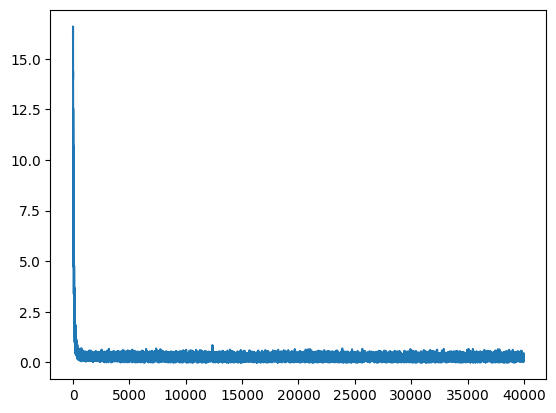

In [110]:
plt.plot(stepi, lossi)

In [111]:
emb = C[vali_dataX]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, vali_dataY)
loss

tensor(12.8043, grad_fn=<NllLossBackward0>)

In [112]:
emb = C[test_dataX]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, test_dataY)
loss

tensor(14.4011, grad_fn=<NllLossBackward0>)

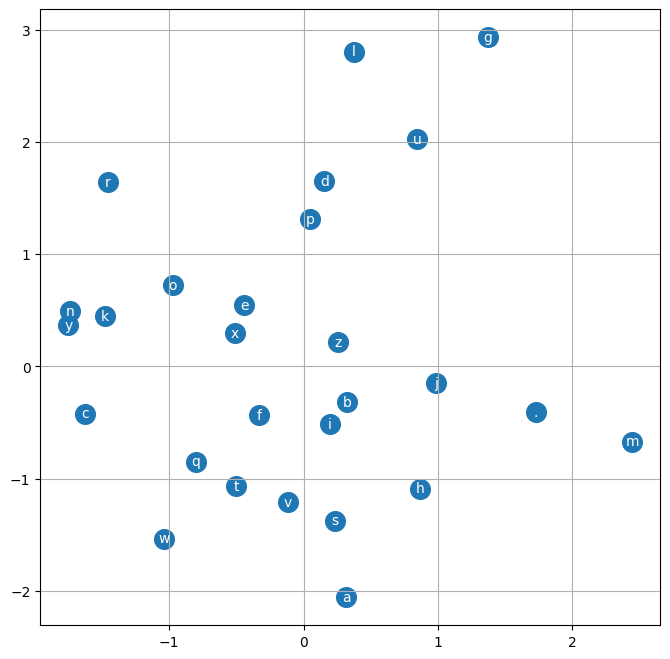

In [116]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")